In [1]:
import tensorflow as tf
from cnn_classifier import *

2023-03-09 02:46:21.184842: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Test build model

In [2]:
input_shape = (128,128,3)
in_channels = 3
out_classes = 4
filters = [10,20,30,40,50]
kernel_size = [3,3,3,3,3]
strides = [2,2,2,2,2]
padding='valid'
activation='relu'
downsampling_mode='max'
flatten=False
fc=[50,20]
dropout = 0.5
spatial_dropout = 0.2
lambda_l2 = 0.0001
lrate = 0.001
loss = 'sparse_categorical_crossentropy'
metrics = None

In [3]:
filters = [16,24,32,40,48,56,64]
kernel_size = [5,3,3,3,3,3,3]
strides = [2,2,1,2,1,1,1]
fc=[64,16]

In [4]:
model = create_cnn_classifier_network(input_shape, in_channels, out_classes, filters, kernel_size, strides, padding=padding, activation=activation, downsampling_mode=downsampling_mode, flatten=flatten, fc=fc)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 24)        3480      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 24)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        6944      
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 40)        1

2023-03-09 02:46:26.196665: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 40)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 48)        17328     
                                                                 
 conv2d_5 (Conv2D)           (None, 9, 9, 56)          24248     
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 64)          32320     
                                                                 
 global_max_pooling2d (Globa  (None, 64)               0         
 lMaxPooling2D)                                                  
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (

In [5]:
x = tf.random.normal((1,128,128,3))
y = model(x)
print(y)

tf.Tensor([[0.23734425 0.21123447 0.257906   0.2935153 ]], shape=(1, 4), dtype=float32)


# View Results

In [6]:
import os
import fnmatch
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def read_all_rotations(dirname, filebase):
    '''Read results from dirname from files matching filebase'''
    
    # The set of files in the directory
    files = fnmatch.filter(os.listdir(dirname), filebase)
    files.sort()
    results = []
    
    # Loop over matching files
    for f in files:
        fp = open("%s/%s"%(dirname,f), "rb")
        r = pickle.load(fp)
        fp.close()
        results.append(r)
    return results

In [8]:
filebase = "image_Csize_3_3_3_3_3_Cfilters_10_20_30_40_50_Pool_2_2_2_2_2_Pad_valid_hidden_50_20_drop_0.500_L2_0.000500_LR_0.001000_ntrain_*_rot_*_results.pkl"
results_s = read_all_rotations("results", filebase)
filebase = "image_Csize_5_3_3_3_3_3_3_Cfilters_16_24_32_40_48_56_64_Pool_2_2_1_2_1_1_1_Pad_valid_hidden_64_16_drop_0.500_L2_0.000500_LR_0.001000_ntrain_*_rot_*_results.pkl"
results_d = read_all_rotations("results", filebase)

In [9]:
print(len(results_s),len(results_d)) # should be 5
results_s[0].keys()

5 5


dict_keys(['args', 'predict_validation', 'predict_validation_eval', 'predict_testing', 'predict_testing_eval', 'predict_training', 'predict_training_eval', 'history', 'fname_base'])

In [10]:
results_s[0]['history'].keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])

### FIGURE 1 (shallow)

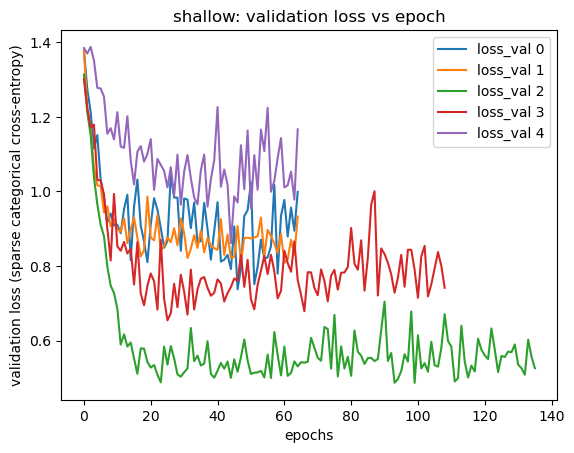

In [11]:
# plot learning curve
plt.figure()
plt.plot(results_s[0]['history']['val_loss'], label='loss_val 0')
plt.plot(results_s[1]['history']['val_loss'], label='loss_val 1')
plt.plot(results_s[2]['history']['val_loss'], label='loss_val 2')
plt.plot(results_s[3]['history']['val_loss'], label='loss_val 3')
plt.plot(results_s[4]['history']['val_loss'], label='loss_val 4')
plt.ylabel('validation loss (sparse categorical cross-entropy)')
plt.xlabel('epochs')
plt.title('shallow: validation loss vs epoch')
plt.legend()

### FIGURE 2 (shallow)

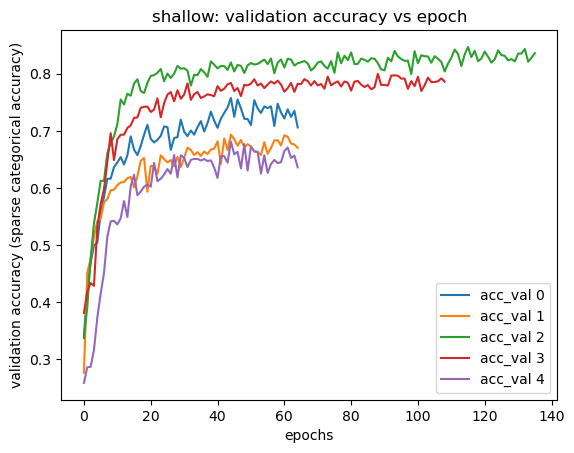

In [12]:
# plot learning curve
plt.figure()
plt.plot(results_s[0]['history']['val_sparse_categorical_accuracy'], label='acc_val 0')
plt.plot(results_s[1]['history']['val_sparse_categorical_accuracy'], label='acc_val 1')
plt.plot(results_s[2]['history']['val_sparse_categorical_accuracy'], label='acc_val 2')
plt.plot(results_s[3]['history']['val_sparse_categorical_accuracy'], label='acc_val 3')
plt.plot(results_s[4]['history']['val_sparse_categorical_accuracy'], label='acc_val 4')
plt.ylabel('validation accuracy (sparse categorical accuracy)')
plt.xlabel('epochs')
plt.title('shallow: validation accuracy vs epoch')
plt.legend()

### FIGURE 1 (deep)

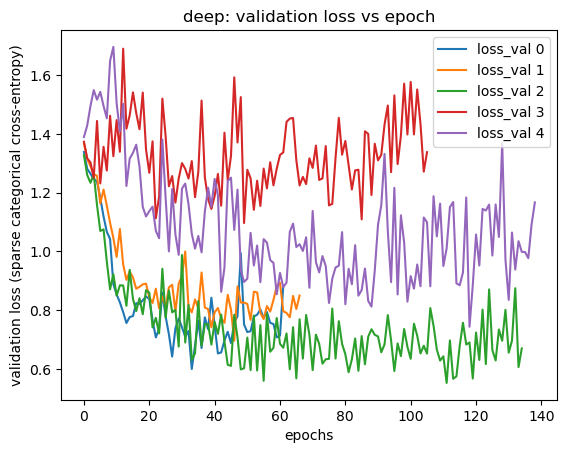

In [13]:
# plot learning curve
plt.figure()
plt.plot(results_d[0]['history']['val_loss'], label='loss_val 0')
plt.plot(results_d[1]['history']['val_loss'], label='loss_val 1')
plt.plot(results_d[2]['history']['val_loss'], label='loss_val 2')
plt.plot(results_d[3]['history']['val_loss'], label='loss_val 3')
plt.plot(results_d[4]['history']['val_loss'], label='loss_val 4')
plt.ylabel('validation loss (sparse categorical cross-entropy)')
plt.xlabel('epochs')
plt.title('deep: validation loss vs epoch')
plt.legend()

### FIGURE 2 (deep)

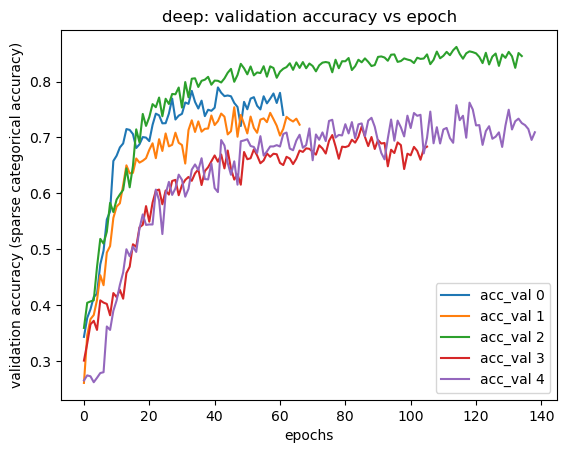

In [14]:
# plot learning curve
plt.figure()
plt.plot(results_d[0]['history']['val_sparse_categorical_accuracy'], label='acc_val 0')
plt.plot(results_d[1]['history']['val_sparse_categorical_accuracy'], label='acc_val 1')
plt.plot(results_d[2]['history']['val_sparse_categorical_accuracy'], label='acc_val 2')
plt.plot(results_d[3]['history']['val_sparse_categorical_accuracy'], label='acc_val 3')
plt.plot(results_d[4]['history']['val_sparse_categorical_accuracy'], label='acc_val 4')
plt.ylabel('validation accuracy (sparse categorical accuracy)')
plt.xlabel('epochs')
plt.title('deep: validation accuracy vs epoch')
plt.legend()

### FIGURE 3

[0.6447873115539551, 0.8623019456863403, 0.7353725433349609, 0.6749812364578247, 0.7130833268165588]
[0.7210175395011902, 0.8723936676979065, 0.7124520540237427, 0.7726703882217407, 0.8048333525657654]


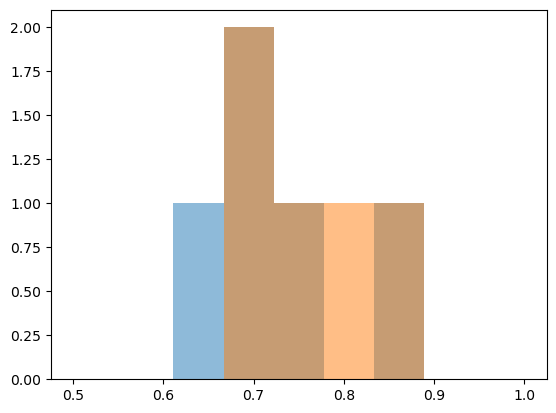

In [15]:
test_eval_shallow = []
test_eval_deep = []
for i in range(5):
    test_eval_shallow.append(results_s[i]['predict_testing_eval'][1])
    test_eval_deep.append(results_d[i]['predict_testing_eval'][1])

bins = np.linspace(0.5, 1, 10)
plt.figure()
plt.hist(test_eval_shallow, bins, alpha = 0.5)
plt.hist(test_eval_deep, bins, alpha = 0.5)
print(test_eval_shallow)
print(test_eval_deep)

In [16]:
from core50 import *

rotation = 0
base_dir = '/home/ikang/datasets/core50_128x128'

core = Core50('core50_df.pkl')

# Set the problem class IDs
objects = [4,5,6,8]
core.set_problem_class_by_equality('class', objects)

# Select only these object classes (remove all others)
core.filter_problem_class()

# Folds by pairs of condition ((1,2), (3,4), ...)
folds = core.create_subsets_by_membership('condition', list(zip(range(1,11,2),range(2,11,2))))

_, _, df_testing = core.create_training_validation_testing(rotation, folds, 3)

# use with mini dataset
df_testing = df_testing[df_testing['fname'].str.contains('0.png')]

ds_testing = tf.data.Dataset.from_tensor_slices(df_testing[['fname', 'problem_class']].to_numpy())

ds_testing = ds_testing.map(lambda x: tf.py_function(func=Core50.prepare_single_example, inp=[base_dir, x], Tout=(tf.float32, tf.int8)))

#ds_testing.map(lambda x: x*2)

Training:  [0 1 2]
Validation:  3
Testing:  4
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [17]:
model_s = tf.keras.models.load_model('./results/image_Csize_3_3_3_3_3_Cfilters_10_20_30_40_50_Pool_2_2_2_2_2_Pad_valid_hidden_50_20_drop_0.500_L2_0.000500_LR_0.001000_ntrain_03_rot_00_model')
model_d = tf.keras.models.load_model('./results/image_Csize_5_3_3_3_3_3_3_Cfilters_16_24_32_40_48_56_64_Pool_2_2_1_2_1_1_1_Pad_valid_hidden_64_16_drop_0.500_L2_0.000500_LR_0.001000_ntrain_03_rot_00_model')

### FIGURE 4

true: 3 shallow: 2 deep: 3
[[1.8895883e-03 1.9200490e-04 6.7330420e-01 3.2461420e-01]]
[[8.7170462e-12 2.6207593e-08 2.7315674e-04 9.9972683e-01]]
true: 2 shallow: 3 deep: 3
[[3.6221568e-06 1.0034988e-06 4.1796789e-02 9.5819861e-01]]
[[1.0070282e-06 1.4151845e-05 3.8388766e-02 9.6159613e-01]]
true: 0 shallow: 0 deep: 0
[[0.74068975 0.24451767 0.01096271 0.00382983]]
[[0.9432488  0.0536681  0.00190566 0.00117733]]
true: 0 shallow: 0 deep: 0
[[0.9029917  0.06427876 0.02845476 0.00427472]]
[[9.9991548e-01 8.4243562e-05 2.0155557e-07 1.0522464e-08]]


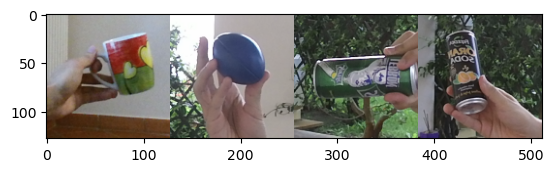

In [18]:
shuffle = ds_testing.shuffle(1000)
list = []
for element in shuffle.take(4):
    list.append(element[0].numpy())
    predict_s = model_s.predict(element[0][None,:,:,:], verbose=False)
    predict_d = model_d.predict(element[0][None,:,:,:], verbose=False)
    print('true:', element[1].numpy(), 'shallow:', np.argmax(predict_s), 'deep:', np.argmax(predict_d))
    print(predict_s)
    print(predict_d)
stack = np.hstack(list)
plt.figure()
plt.imshow(stack)

# Reflection

How many parameters were needed by your shallow and deep networks?

    40,070 and 102,360, respectively

What can you conclude from the validation accuracy learning curves for each of the shallow and deep networks? How confident are you that you have created models that you can trust?

    There is quite a bit of difference in accuracy between the models. I feel slightly confident about trusting my models, as some are wrong a little too often, but they all work to some degree.

Did your shallow or deep network perform better with respect to the test set? (no need for a statistical argument here)

    deep, since it outperformed shallow in 4/5 rotations